In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
sys.path.append(os.path.join('..','UTILS'))
from cosamp_fn import cosamp
# cosamp function is available at https://github.com/avirmaux/CoSaMP

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [10]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [11]:
## Randomly sample signal
p = 128 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

In [12]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
xrecon = idct(s) # reconstruct full signal

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


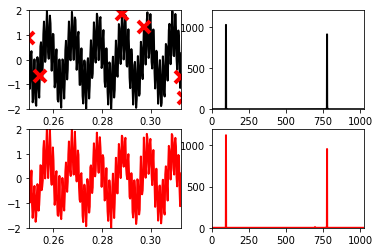

In [5]:
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',LineWidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',LineWidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',LineWidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',LineWidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',LineWidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

In [6]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x

In [13]:
Theta.shape

(128, 4096)

In [14]:
y.shape

(128,)